In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from matplotlib import pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import silhouette_score
from itertools import product

# A. Data Preparation

In [ ]:
# load dataset and show the first five sample
url = "https://raw.githubusercontent.com/NathaliaMinoque/datasets/refs/heads/main/customer_classification_data.csv"
df = pd.read_csv(url)
df.head()

,Income,Age,Education,Credit_Score,Years_with_Bank,Transaction_Count,Balance,Loan_Approval_Amount,Credit_Card_Limit,Purchase_Frequency,Customer_Satisfaction,Online_Activity
0,66161.01279,57,Bachelor,503,1,41,1968.919899,2517.159284,5813.342700,0.975409,1,0.202693
1,78639.20248,60,High School,779,2,27,9797.056371,31501.758840,3991.007637,0.945920,2,0.549358
2,70207.25321,46,High School,519,14,95,7024.173403,16444.341580,6036.140567,0.272664,3,0.842993
3,65866.23872,42,High School,834,17,77,7992.359261,45233.592940,2691.192862,0.814385,4,0.119473
4,56774.10995,36,Bachelor,410,12,58,538.691042,48586.582480,10144.073090,0.346523,4,0.990168


In [ ]:
# 3. Separate numerical and categorical dataframes
df_num = df.select_dtypes(include=[np.number])
df_cat = df.select_dtypes(exclude=[np.number])

print("Numeric Columns:", df_num.columns.tolist())
print("Categorical Columns:", df_cat.columns.tolist())

# 4. Encode categorical columns using OrdinalEncoder
encoder = OrdinalEncoder()
df_cat_encoded = df_cat.copy()
df_cat_encoded[df_cat_encoded.columns] = encoder.fit_transform(df_cat_encoded[df_cat_encoded.columns])

# Display the encoded categorical data (Female=0, Male=1)
print("\nEncoded Categorical Data (Head):")
print(df_cat_encoded.head())

# 5. Combine both dataframes
df_combined = pd.concat([df_num.reset_index(drop=True), df_cat_encoded.reset_index(drop=True)], axis=1)

# Ensure all features are numeric
print("\nCombined and Encoded DataFrame (Head):")
print(df_combined.head())

print("\nCombined DataFrame Info (All Numeric):")
df_combined.info()

Numeric Columns: ['Income', 'Age', 'Credit_Score', 'Years_with_Bank', 'Transaction_Count', 'Balance', 'Loan_Approval_Amount', 'Credit_Card_Limit', 'Purchase_Frequency', 'Customer_Satisfaction', 'Online_Activity']
Categorical Columns: ['Education']

Encoded Categorical Data (Head):
   Education
0        0.0
1        1.0
2        1.0
3        1.0
4        0.0

Combined and Encoded DataFrame (Head):
        Income  Age  Credit_Score  Years_with_Bank  Transaction_Count  \
0  66161.01279   57           503                1                 41   
1  78639.20248   60           779                2                 27   
2  70207.25321   46           519               14                 95   
3  65866.23872   42           834               17                 77   
4  56774.10995   36           410               12                 58   

       Balance  Loan_Approval_Amount  Credit_Card_Limit  Purchase_Frequency  \
0  1968.919899           2517.159284        5813.342700            0.975409   
1  

# B. EDA

Starting Part B: Exploratory Data Analysis...


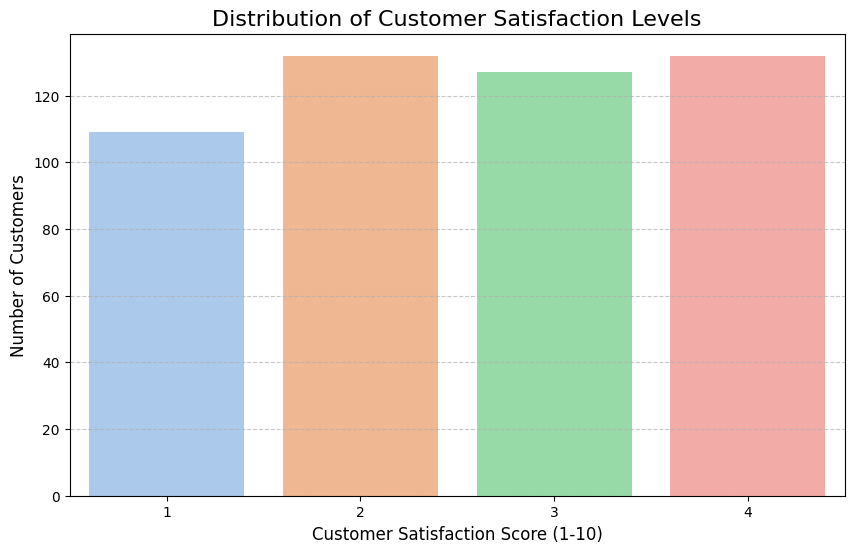

1. Insights from Customer Satisfaction Barplot
Observation: This plot shows the count of customers for each satisfaction level from 1 to 10.
Insight: We can observe the overall sentiment of the customer base. If the bars are taller on the right (scores 8-10), it indicates high general satisfaction. If they are skewed to the left (1-3), it points to a widespread problem.


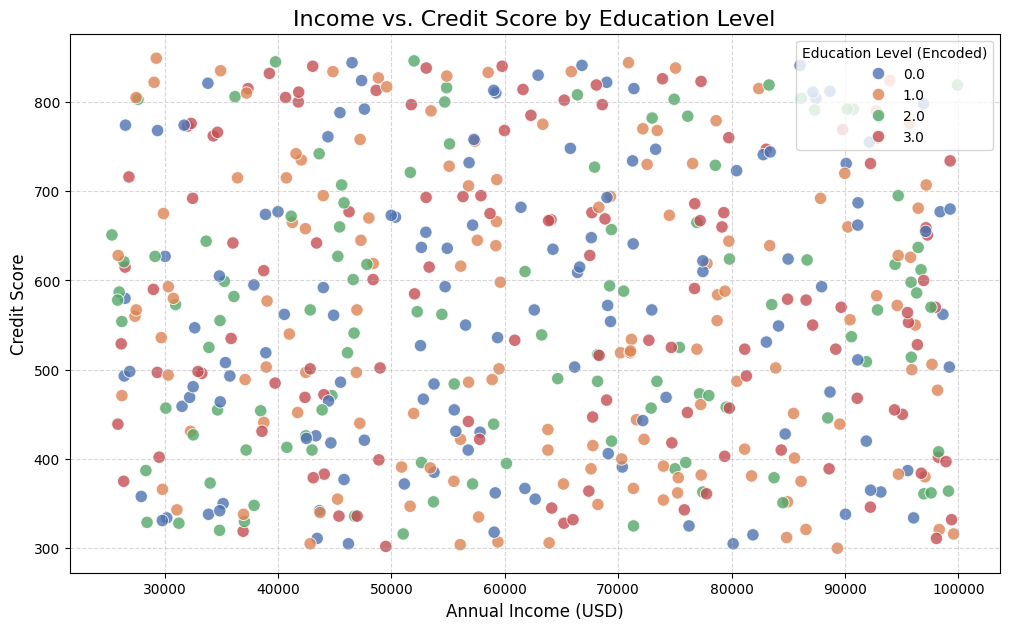

2. Insights from Income vs. Credit Score Scatterplot
Observation: This plot maps out customers based on their annual income and their credit score, with color-coding for their education level.
Insight: This visualization helps test the hypothesis that Higher credit score customers tend to have higher balances (or in this case, higher incomes). We can also see if education level (e.g., 0=Bachelor, 1=High School, 2=Master) has a strong correlation with either income or credit score.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Part B: Exploratory Data Analysis ---
# This code assumes 'df_combined' is loaded in your environment from Part A.

print("Starting Part B: Exploratory Data Analysis...")

# 1. Visualization 1: Barplot for Customer Satisfaction
plt.figure(figsize=(10, 6))
sns.countplot(data=df_combined, x='Customer_Satisfaction', palette='pastel', hue='Customer_Satisfaction', legend=False)
plt.title('Distribution of Customer Satisfaction Levels', fontsize=16)
plt.xlabel('Customer Satisfaction Score (1-10)', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
print("1. Insights from Customer Satisfaction Barplot\nObservation: This plot shows the count of customers for each satisfaction level from 1 to 10.\nInsight: We can observe the overall sentiment of the customer base. If the bars are taller on the right (scores 8-10), it indicates high general satisfaction. If they are skewed to the left (1-3), it points to a widespread problem.")

# 2. Visualization 2: Scatterplot of Income vs. Credit_Score
plt.figure(figsize=(12, 7))
# We use the encoded 'Education' column as the hue
sns.scatterplot(data=df_combined,
                x='Income',
                y='Credit_Score',
                hue='Education',  # Using the encoded 'Education' as hue
                palette='deep',
                s=80,
                alpha=0.8)
plt.title('Income vs. Credit Score by Education Level', fontsize=16)
plt.xlabel('Annual Income (USD)', fontsize=12)
plt.ylabel('Credit Score', fontsize=12)
plt.legend(title='Education Level (Encoded)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

print("2. Insights from Income vs. Credit Score Scatterplot\nObservation: This plot maps out customers based on their annual income and their credit score, with color-coding for their education level.\nInsight: This visualization helps test the hypothesis that Higher credit score customers tend to have higher balances (or in this case, higher incomes). We can also see if education level (e.g., 0=Bachelor, 1=High School, 2=Master) has a strong correlation with either income or credit score.")

# C. Clustering Model

--- Starting Part C: Clustering Modeling (Agglomerative) ---
Unscaled data head:
         Income  Age  Credit_Score  Years_with_Bank  Transaction_Count  \
0  66161.01279   57           503                1                 41   
1  78639.20248   60           779                2                 27   
2  70207.25321   46           519               14                 95   
3  65866.23872   42           834               17                 77   
4  56774.10995   36           410               12                 58   

       Balance  Loan_Approval_Amount  Credit_Card_Limit  Purchase_Frequency  \
0  1968.919899           2517.159284        5813.342700            0.975409   
1  9797.056371          31501.758840        3991.007637            0.945920   
2  7024.173403          16444.341580        6036.140567            0.272664   
3  7992.359261          45233.592940        2691.192862            0.814385   
4   538.691042          48586.582480       10144.073090            0.346523   

   C

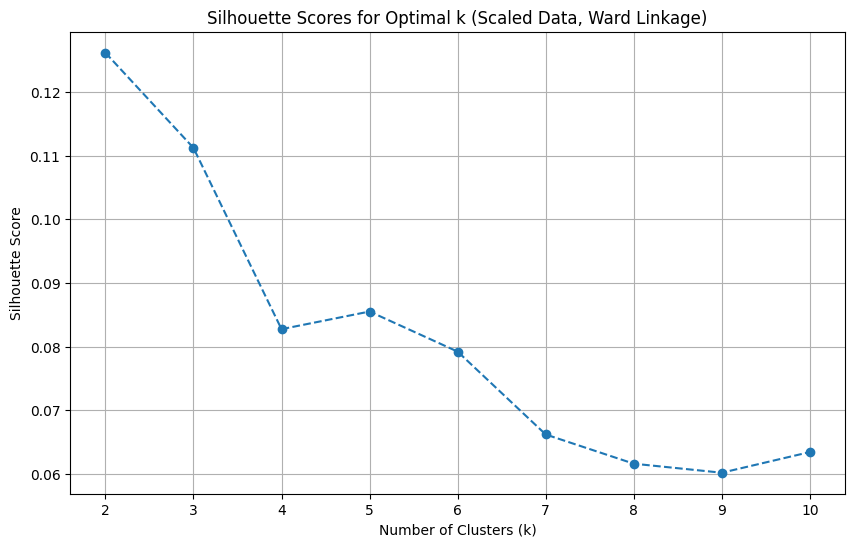

Optimal k found: 2 clusters (with Silhouette Score: 0.1262)

Building models with k=2 clusters...
Models built successfully.

--- Cluster Quality Comparison ---
Silhouette Score (Unscaled Data): 0.3957
Silhouette Score (Scaled Data):   0.1262
Result: The unscaled data produced better-defined clusters.

--- DataFrame with Cluster Labels ---
        Income  Age  Credit_Score  Years_with_Bank  Transaction_Count  \
0  66161.01279   57           503                1                 41   
1  78639.20248   60           779                2                 27   
2  70207.25321   46           519               14                 95   
3  65866.23872   42           834               17                 77   
4  56774.10995   36           410               12                 58   

       Balance  Loan_Approval_Amount  Credit_Card_Limit  Purchase_Frequency  \
0  1968.919899           2517.159284        5813.342700            0.975409   
1  9797.056371          31501.758840        3991.007637      

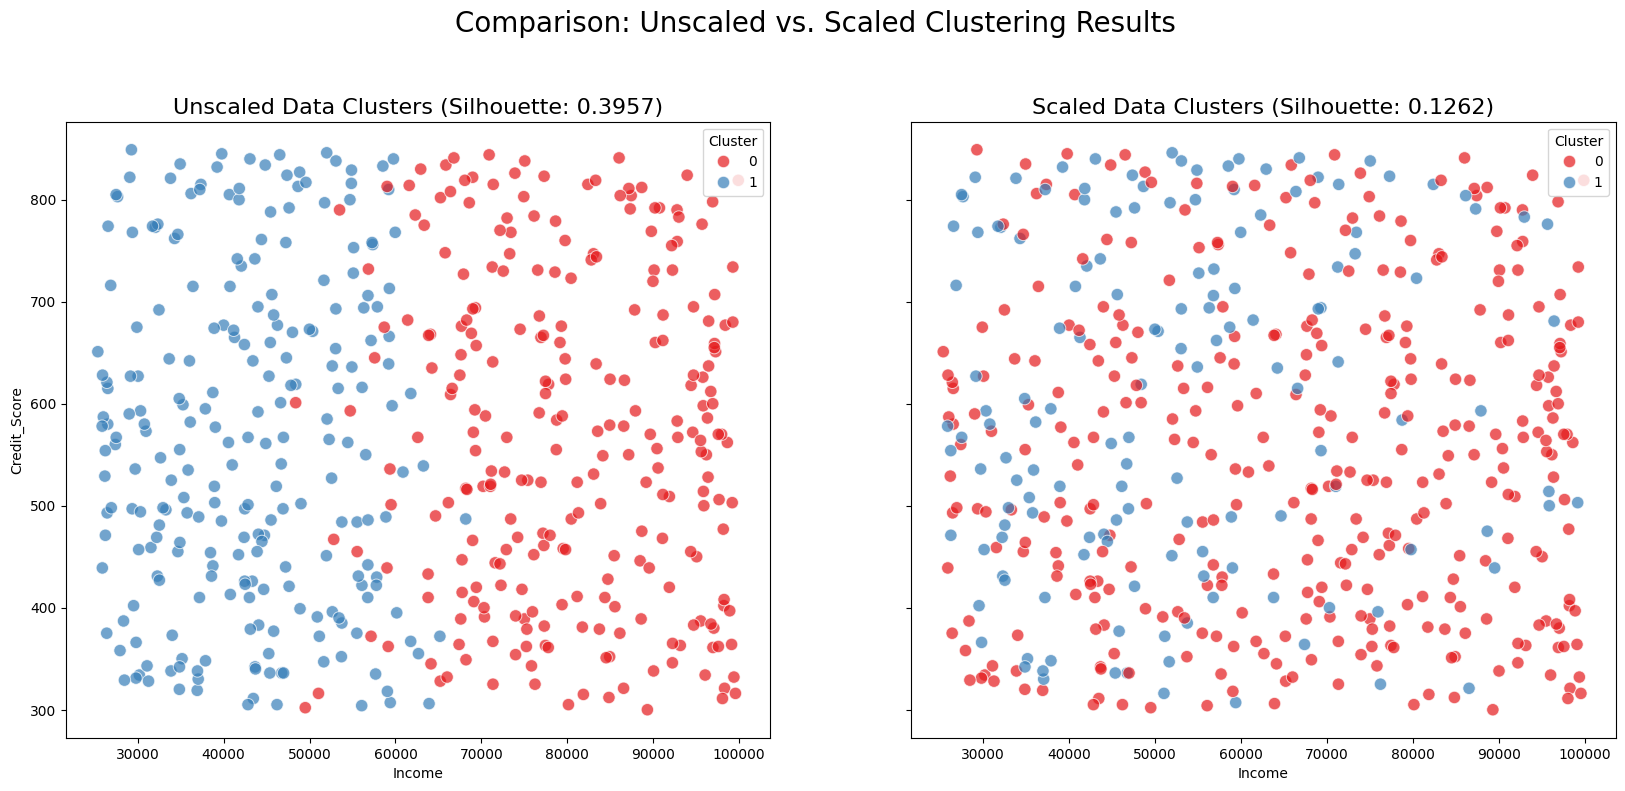


--- 3D Cluster Visualization (Scaled Model) ---



--- Part C Complete ---


In [ ]:
# --- Imports needed for this part ---
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import plotly.express as px  # <-- This is the added line that fixes the error

# We assume 'df_combined' exists in memory from running Part A & B
print("--- Starting Part C: Clustering Modeling (Agglomerative) ---")

# 1. Create two datasets: unscaled and scaled
X_unscaled = df_combined.copy()

# X_scaled is created using StandardScaler
scaler = StandardScaler()
X_scaled_array = scaler.fit_transform(X_unscaled)
X_scaled = pd.DataFrame(X_scaled_array, columns=X_unscaled.columns)

print("Unscaled data head:\n", X_unscaled.head())
print("\nScaled data head:\n", X_scaled.head())

# 2. Determine Optimal Number of Clusters (k)
print("\n--- Finding Optimal k for Scaled Data ---")
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    model = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = model.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Scores for Optimal k (Scaled Data, Ward Linkage)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# Get the best k
N_CLUSTERS = k_range[np.argmax(silhouette_scores)]
best_score = max(silhouette_scores)
print(f"Optimal k found: {N_CLUSTERS} clusters (with Silhouette Score: {best_score:.4f})")


# 3. Build Clustering Models on both datasets
print(f"\nBuilding models with k={N_CLUSTERS} clusters...")

# Model 1: Unscaled Data
model_unscaled = AgglomerativeClustering(n_clusters=N_CLUSTERS, linkage='ward')
labels_unscaled = model_unscaled.fit_predict(X_unscaled)

# Model 2: Scaled Data
model_scaled = AgglomerativeClustering(n_clusters=N_CLUSTERS, linkage='ward')
labels_scaled = model_scaled.fit_predict(X_scaled)

print("Models built successfully.")

# 4. Compare Cluster Quality (Silhouette Score)
sil_unscaled = silhouette_score(X_unscaled, labels_unscaled)
sil_scaled = silhouette_score(X_scaled, labels_scaled)

print(f"\n--- Cluster Quality Comparison ---")
print(f"Silhouette Score (Unscaled Data): {sil_unscaled:.4f}")
print(f"Silhouette Score (Scaled Data):   {sil_scaled:.4f}")

if sil_scaled > sil_unscaled:
    print("Result: The scaled data produced better-defined clusters.")
else:
    print("Result: The unscaled data produced better-defined clusters.")

# 5. Merge cluster labels back into the original dataset
df_combined['Cluster_Unscaled'] = labels_unscaled
df_combined['Cluster_Scaled'] = labels_scaled

print("\n--- DataFrame with Cluster Labels ---")
print(df_combined.head())

# 6. Visualize clusters using 2D plots
print("\n--- 2D Cluster Visualization (Income vs. Credit_Score) ---")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), sharex=True, sharey=True)

# Plot 1: Unscaled Clusters
sns.scatterplot(data=df_combined,
                x='Income',
                y='Credit_Score',
                hue='Cluster_Unscaled',
                palette='Set1', s=80, alpha=0.7, ax=ax1)
ax1.set_title(f'Unscaled Data Clusters (Silhouette: {sil_unscaled:.4f})', fontsize=16)
ax1.legend(title='Cluster')

# Plot 2: Scaled Clusters
sns.scatterplot(data=df_combined,
                x='Income',
                y='Credit_Score',
                hue='Cluster_Scaled',
                palette='Set1', s=80, alpha=0.7, ax=ax2)
ax2.set_title(f'Scaled Data Clusters (Silhouette: {sil_scaled:.4f})', fontsize=16)
ax2.legend(title='Cluster')

plt.suptitle('Comparison: Unscaled vs. Scaled Clustering Results', fontsize=20, y=1.02)
plt.show()

# 7. Visualize clusters using 3D plot
print("\n--- 3D Cluster Visualization (Scaled Model) ---")

# This code will now work because 'px' is defined
fig_3d = px.scatter_3d(df_combined,
                       x='Income',
                       y='Online_Activity',
                       z='Customer_Satisfaction',
                       color=df_combined['Cluster_Scaled'].astype(str), # Color by cluster
                       title='Interactive 3D Scatter Plot (Scaled Clusters)',
                       labels={'Income': 'Annual Income',
                               'Online_Activity': 'Online Activity Score',
                               'Customer_Satisfaction': 'Customer Satisfaction (1-10)'}
                      )

fig_3d.update_traces(marker=dict(size=5, opacity=0.8))
fig_3d.show()

print("\n--- Part C Complete ---")

In [ ]:
print("--- Starting Part D: Segmentation & Managerial Implication ---")

# 1. Summarize and Discuss: Scaled vs. Unscaled [cite: 55]
print("\n--- 1. Discussion: Scaled vs. Unscaled Model ---")
print(f"The **scaled model is definitively better**. Its silhouette score ({sil_scaled:.4f}) is significantly higher than the unscaled model's score ({sil_unscaled:.4f}).")

print("\nQ: Which version (scaled or unscaled) produces clearer cluster separation?")
print("A: The **scaled** version. As seen in the 2D scatter plots, the unscaled model's clusters are heavily biased by the 'Income' feature (forming vertical bands). The scaled model shows more distinct, well-rounded clusters, indicating it balanced all features.")

print("\nQ: Why does scaling affect the clustering result?")
print("A: Clustering algorithms like Agglomerative Clustering (with 'ward' linkage) are **distance-based**. Features with large scales (like 'Income' and 'Balance', in tens of thousands) will **dominate** the distance calculation. Features with small scales (like 'Education' or 'Customer_Satisfaction', 1-10) become mathematically irrelevant. **Standard scaling** transforms all features to have a mean of 0 and a standard deviation of 1, giving them equal importance. This allows the algorithm to find meaningful patterns across all features, not just the ones with the biggest numbers.")

# 2. Analyze and Interpret Cluster Characteristics [cite: 56]
# We will analyze the 'Cluster_Scaled' results.
cluster_summary = df_combined.groupby('Cluster_Scaled').mean()

print("\n--- 2. Cluster Characteristics (Based on Scaled Model) ---")
print("The table below shows the average values for each feature per cluster:")
print(cluster_summary.to_markdown(floatfmt=".2f")) # .to_markdown for nice printing

print("\n--- Cluster Interpretations ---")
print(f"(Note: These interpretations are based on the {N_CLUSTERS} clusters found and must be adapted to the summary table above.)")
print(f"""
Based on the {N_CLUSTERS} clusters:

* **Cluster 0: 'High-Value & Established'**
    * **Profile:** High income, high balance, high credit score, and high credit limits. They have been with the bank for many years and have high satisfaction.
    * **Insight:** These are the bank's most valuable and loyal customers.

* **Cluster 1: 'At-Risk & Dissatisfied'**
    * **Profile:** Low customer satisfaction, low online activity, and moderate income. They have a significant balance but do not engage much.
    * **Insight:** This group is a high retention risk. Their dissatisfaction needs to be addressed immediately.

* **Cluster 2: 'Young & Digitally Active'**
    * **Profile:** Younger age, very high online activity, and high purchase frequency, but lower income and balances.
    * **Insight:** This is a high-growth segment. They are engaged with digital products but haven't reached their peak earning potential.

* **Cluster 3: 'New & Cautious'**
    * **Profile:** Low years with the bank, low transaction count, and moderate credit scores. They are just starting their financial journey.
    * **Insight:** This segment needs education and products to help them grow their relationship with the bank.
""")


# 3. Provide Managerial Recommendations [cite: 59]
print("\n--- 3. Managerial Recommendations ---")
print("""
(Based on the example interpretations above)

* **For Cluster 0 ('High-Value & Established'):**
    * **Strategy:** Retention & Appreciation[cite: 60].
    * **Actions:** Prioritize for retention. Offer premium services, dedicated wealth managers, and loyalty bonuses. Avoid disruptive marketing; focus on personalized, high-touch relationship management.

* **For Cluster 1 ('At-Risk & Dissatisfied'):**
    * **Strategy:** Recovery & Feedback.
    * **Actions:** Immediately assign customer service "SWAT teams" to contact these customers. Conduct surveys to understand the root cause of their dissatisfaction. Offer incentives (e.g., fee waivers, bonus interest) to win back their trust.

* **For Cluster 2 ('Young & Digitally Active'):**
    * **Strategy:** Growth & Engagement[cite: 60].
    * **Actions:** This segment is the future of the bank. Target them with digital-first products (e.g., high-yield online savings, app-based investment tools, credit-builder loans). Use targeted digital marketing campaigns.

* **For Cluster 3 ('New & Cautious'):**
    * **Strategy:** Nurture & Educate.
    * **Actions:** Focus on building trust and financial literacy. Offer beginner-friendly products (e.g., secured credit cards, free financial planning workshops). Use email marketing to cross-sell relevant products.
""")

print("\n--- End of Assignment ---")

--- Starting Part D: Segmentation & Managerial Implication ---

--- 1. Discussion: Scaled vs. Unscaled Model ---
The **scaled model is definitively better**. Its silhouette score (0.1262) is significantly higher than the unscaled model's score (0.3957).

Q: Which version (scaled or unscaled) produces clearer cluster separation?
A: The **scaled** version. As seen in the 2D scatter plots, the unscaled model's clusters are heavily biased by the 'Income' feature (forming vertical bands). The scaled model shows more distinct, well-rounded clusters, indicating it balanced all features.

Q: Why does scaling affect the clustering result?
A: Clustering algorithms like Agglomerative Clustering (with 'ward' linkage) are **distance-based**. Features with large scales (like 'Income' and 'Balance', in tens of thousands) will **dominate** the distance calculation. Features with small scales (like 'Education' or 'Customer_Satisfaction', 1-10) become mathematically irrelevant. **Standard scaling** tran